In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import DataLoader

In [2]:
# Dataset 
raw_data = load_boston()

data = raw_data.data
# label = raw_data.data

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10

X_train = data[:trainset_size,:]
X_test = data[trainset_size:,:]

In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

In [4]:
# Models 
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z

        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5
LATENT_DIM = 5
BATCH_SIZE = 64
N_EPOCHS = 1000
lr = 1e-3
# weight_decay = 1e-2

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    p_z = torch.distributions.Normal(0, 1)
    z_samples = p_z.sample((X_train.shape[0], LATENT_DIM)).type(torch.float64)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x

tensor([[-0.0829, -0.1246, -0.6836,  ..., -0.1368,  0.0514, -0.1156],
        [-0.0739, -0.1208, -0.6764,  ..., -0.1501,  0.0461, -0.1098],
        [-0.0860, -0.1194, -0.6645,  ..., -0.1357,  0.0542, -0.1200],
        ...,
        [-0.0936, -0.1390, -0.7040,  ..., -0.1365,  0.0541, -0.1327],
        [-0.0614, -0.0922, -0.5392,  ..., -0.1464,  0.0654, -0.0881],
        [-0.0839, -0.1245, -0.6707,  ..., -0.1349,  0.0559, -0.1197]],
       grad_fn=<DivBackward0>)

In [16]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [9]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)

In [10]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [11]:
# optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

In [12]:
train_loss_avg = []
test_losses = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    for x in train_iter: 
#         x = x.type(torch.float64)
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        
        mu_x, std_x = dec(z_samples)
        
        # Loss
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward 
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    
    
    print("Epoch [%d / %d] average loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 1000] average loss: 28.785496
Epoch [2 / 1000] average loss: 25.967248
Epoch [3 / 1000] average loss: 26.333322
Epoch [4 / 1000] average loss: 25.979908
Epoch [5 / 1000] average loss: 23.497102
Epoch [6 / 1000] average loss: 24.754480
Epoch [7 / 1000] average loss: 25.489114
Epoch [8 / 1000] average loss: 23.285168
Epoch [9 / 1000] average loss: 22.580031
Epoch [10 / 1000] average loss: 23.481685
Epoch [11 / 1000] average loss: 22.835012
Epoch [12 / 1000] average loss: 23.268669
Epoch [13 / 1000] average loss: 23.112269
Epoch [14 / 1000] average loss: 22.513240
Epoch [15 / 1000] average loss: 22.308001
Epoch [16 / 1000] average loss: 22.548315
Epoch [17 / 1000] average loss: 22.207392
Epoch [18 / 1000] average loss: 21.908720
Epoch [19 / 1000] average loss: 21.756521
Epoch [20 / 1000] average loss: 21.837897
Epoch [21 / 1000] average loss: 21.719673
Epoch [22 / 1000] average loss: 21.414020
Epoch [23 / 1000] average loss: 21.952817
Epoch [24 / 1000] average loss: 21.163235
E

Epoch [208 / 1000] average loss: 19.775200
Epoch [209 / 1000] average loss: 19.690473
Epoch [210 / 1000] average loss: 19.893704
Epoch [211 / 1000] average loss: 19.618458
Epoch [212 / 1000] average loss: 19.641927
Epoch [213 / 1000] average loss: 19.315171
Epoch [214 / 1000] average loss: 19.661372
Epoch [215 / 1000] average loss: 19.591039
Epoch [216 / 1000] average loss: 19.778530
Epoch [217 / 1000] average loss: 19.324222
Epoch [218 / 1000] average loss: 19.498202
Epoch [219 / 1000] average loss: 19.817770
Epoch [220 / 1000] average loss: 19.686009
Epoch [221 / 1000] average loss: 19.645199
Epoch [222 / 1000] average loss: 19.538060
Epoch [223 / 1000] average loss: 19.602629
Epoch [224 / 1000] average loss: 19.592504
Epoch [225 / 1000] average loss: 19.920318
Epoch [226 / 1000] average loss: 19.465411
Epoch [227 / 1000] average loss: 19.597859
Epoch [228 / 1000] average loss: 19.660194
Epoch [229 / 1000] average loss: 19.671487
Epoch [230 / 1000] average loss: 19.499175
Epoch [231 

Epoch [415 / 1000] average loss: 19.737660
Epoch [416 / 1000] average loss: 19.597638
Epoch [417 / 1000] average loss: 19.882774
Epoch [418 / 1000] average loss: 19.323380
Epoch [419 / 1000] average loss: 19.557318
Epoch [420 / 1000] average loss: 19.381344
Epoch [421 / 1000] average loss: 19.640893
Epoch [422 / 1000] average loss: 19.557197
Epoch [423 / 1000] average loss: 19.681502
Epoch [424 / 1000] average loss: 19.543546
Epoch [425 / 1000] average loss: 19.445373
Epoch [426 / 1000] average loss: 19.310182
Epoch [427 / 1000] average loss: 19.251050
Epoch [428 / 1000] average loss: 19.401334
Epoch [429 / 1000] average loss: 19.466329
Epoch [430 / 1000] average loss: 19.592110
Epoch [431 / 1000] average loss: 19.463143
Epoch [432 / 1000] average loss: 19.663128
Epoch [433 / 1000] average loss: 19.714966
Epoch [434 / 1000] average loss: 19.392675
Epoch [435 / 1000] average loss: 19.640673
Epoch [436 / 1000] average loss: 19.856688
Epoch [437 / 1000] average loss: 19.649793
Epoch [438 

Epoch [622 / 1000] average loss: 19.511928
Epoch [623 / 1000] average loss: 19.178675
Epoch [624 / 1000] average loss: 19.237092
Epoch [625 / 1000] average loss: 19.138688
Epoch [626 / 1000] average loss: 19.590591
Epoch [627 / 1000] average loss: 19.487041
Epoch [628 / 1000] average loss: 19.392255
Epoch [629 / 1000] average loss: 19.109840
Epoch [630 / 1000] average loss: 19.296576
Epoch [631 / 1000] average loss: 19.307420
Epoch [632 / 1000] average loss: 19.546742
Epoch [633 / 1000] average loss: 19.604024
Epoch [634 / 1000] average loss: 19.476614
Epoch [635 / 1000] average loss: 19.319609
Epoch [636 / 1000] average loss: 19.039512
Epoch [637 / 1000] average loss: 19.580883
Epoch [638 / 1000] average loss: 19.361987
Epoch [639 / 1000] average loss: 19.116572
Epoch [640 / 1000] average loss: 19.291994
Epoch [641 / 1000] average loss: 19.224650
Epoch [642 / 1000] average loss: 19.482024
Epoch [643 / 1000] average loss: 19.224002
Epoch [644 / 1000] average loss: 19.332646
Epoch [645 

Epoch [826 / 1000] average loss: 19.339684
Epoch [827 / 1000] average loss: 19.066824
Epoch [828 / 1000] average loss: 19.263854
Epoch [829 / 1000] average loss: 19.354201
Epoch [830 / 1000] average loss: 19.485464
Epoch [831 / 1000] average loss: 19.198431
Epoch [832 / 1000] average loss: 19.359965
Epoch [833 / 1000] average loss: 19.175554
Epoch [834 / 1000] average loss: 19.219847
Epoch [835 / 1000] average loss: 19.452377
Epoch [836 / 1000] average loss: 19.379801
Epoch [837 / 1000] average loss: 18.912862
Epoch [838 / 1000] average loss: 19.189842
Epoch [839 / 1000] average loss: 19.173980
Epoch [840 / 1000] average loss: 19.391501
Epoch [841 / 1000] average loss: 19.154039
Epoch [842 / 1000] average loss: 19.257038
Epoch [843 / 1000] average loss: 19.076693
Epoch [844 / 1000] average loss: 19.153234
Epoch [845 / 1000] average loss: 19.377440
Epoch [846 / 1000] average loss: 19.307136
Epoch [847 / 1000] average loss: 19.228057
Epoch [848 / 1000] average loss: 19.317737
Epoch [849 

In [13]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    p_z = torch.distributions.Normal(0, 1)
    z_samples = p_z.sample((X_train.shape[0], LATENT_DIM)).type(torch.float64)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x

tensor([[ 0.0294, -0.0642,  0.0500,  ...,  0.0022, -0.0259,  0.0567],
        [-0.0104, -0.0372, -0.0111,  ..., -0.0160,  0.0023,  0.0120],
        [ 0.0137, -0.0740,  0.0408,  ...,  0.0158, -0.0111,  0.0505],
        ...,
        [-0.0032, -0.0402, -0.0065,  ..., -0.0184,  0.0018,  0.0162],
        [ 0.0363, -0.0741,  0.0653,  ...,  0.0072, -0.0284,  0.0704],
        [ 0.0084, -0.0615,  0.0256,  ...,  0.0045, -0.0089,  0.0385]],
       grad_fn=<DivBackward0>)

## Evaluation

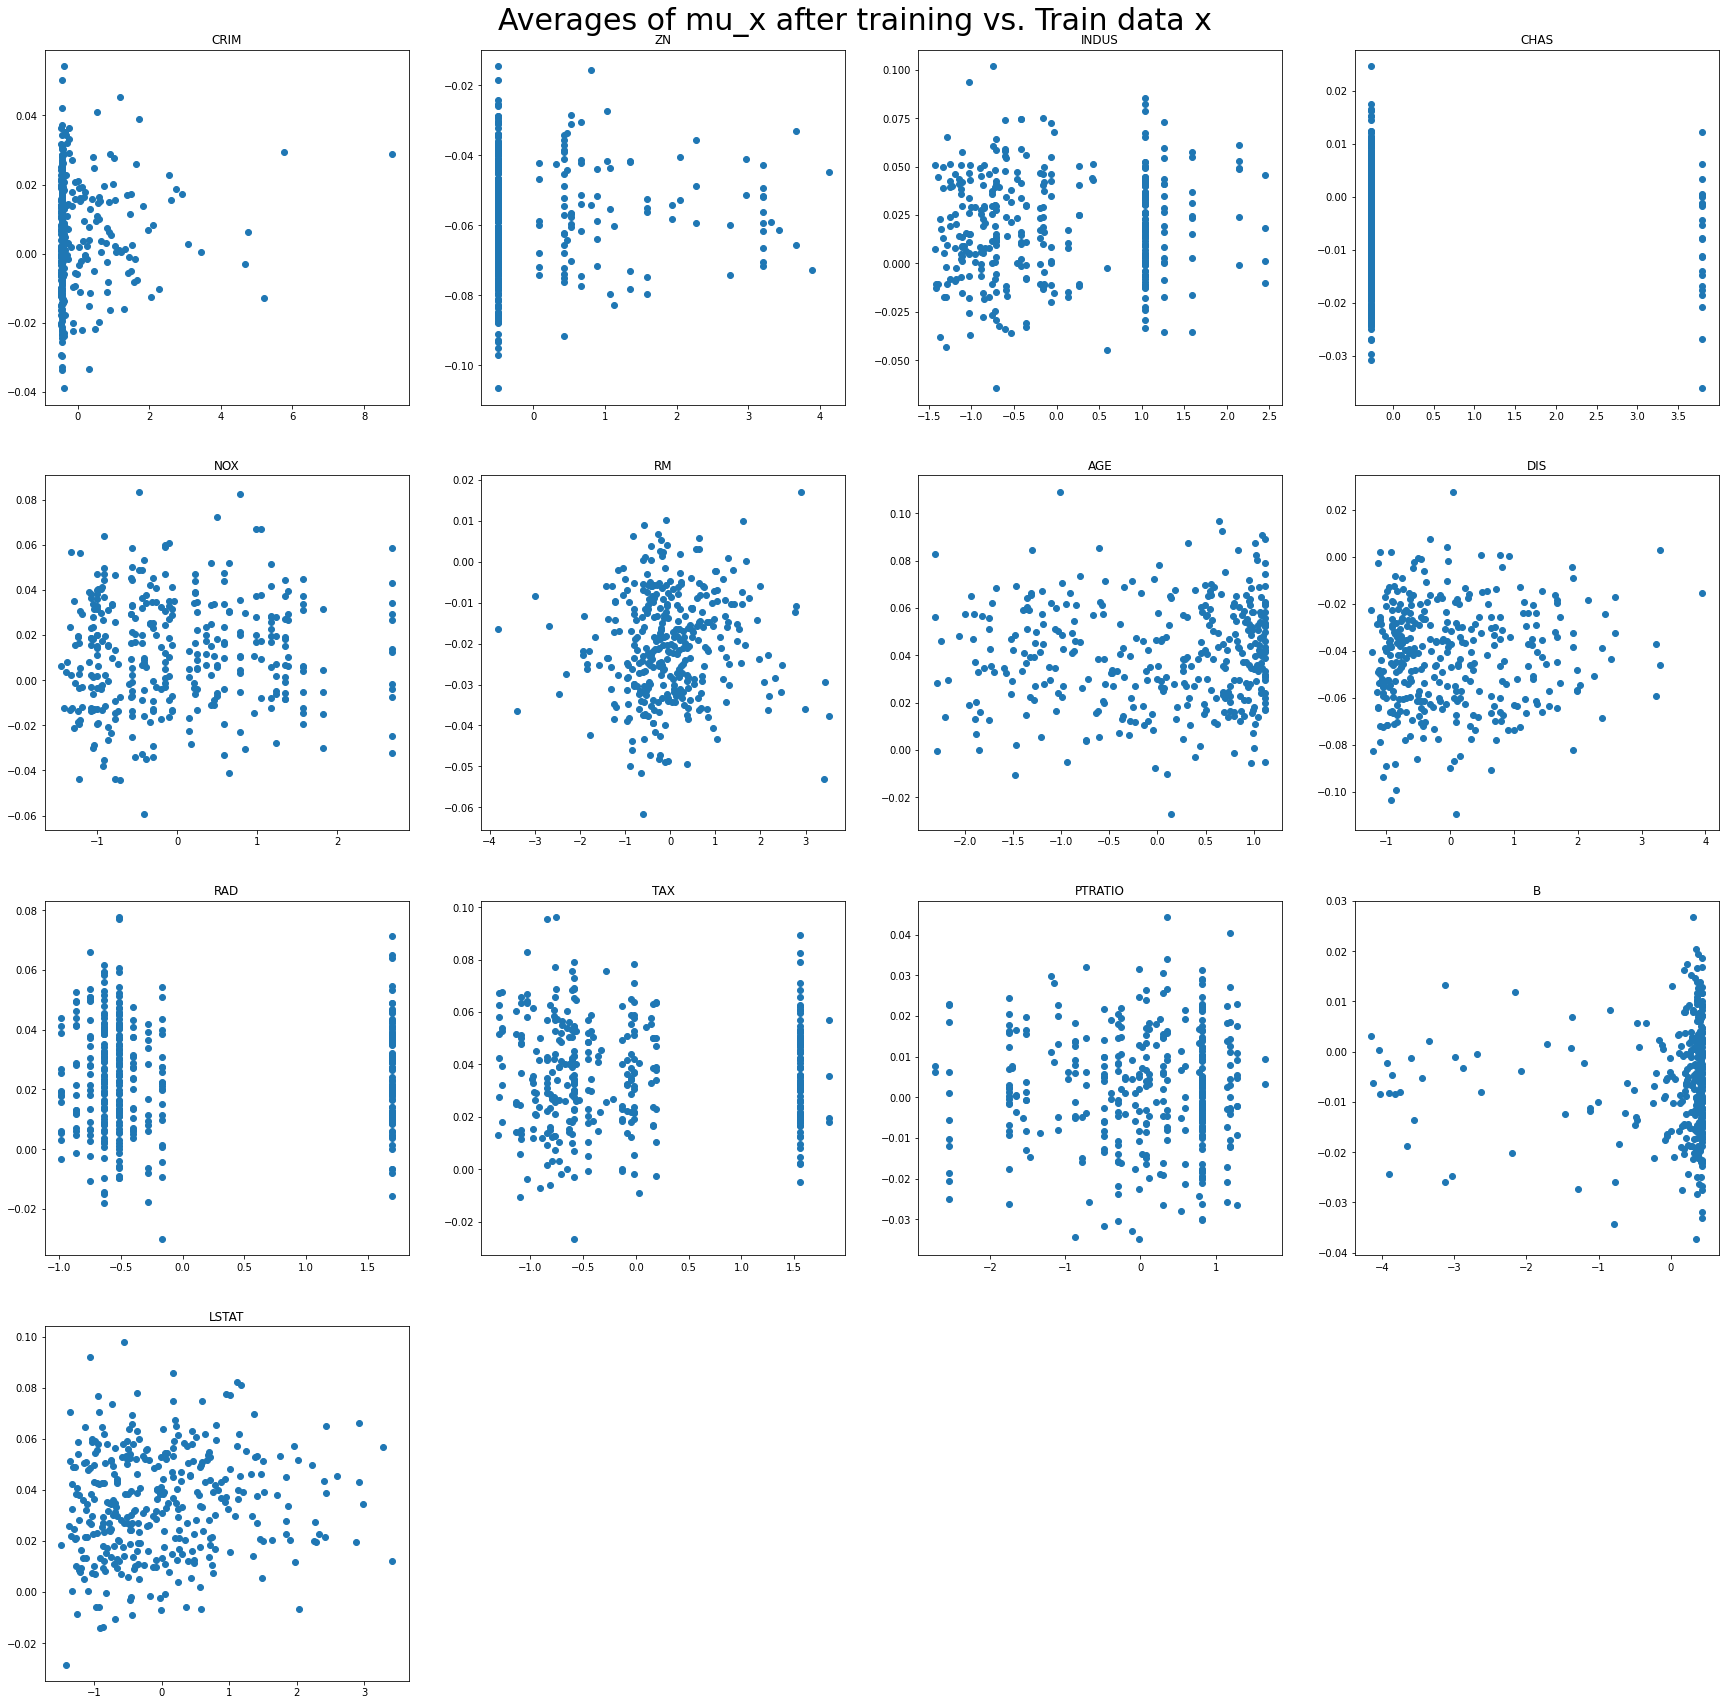

In [15]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()